In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

In [4]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
# data_subfolder = BES_data_folder + dataset_name + os.sep

# (manifest, dataset_filename, dataset_description, dataset_citation,
#  dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

# for df in df_list:
#     if df=="BES_Panel":
# #         globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
#         globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
#     else:
#         globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
#         globals()[df].replace(-1,np.nan,inplace=True)
  
# # (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )

In [ ]:
# helper functions
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()

from pandas._libs.lib import is_integer

def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
    order = weights[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

# CHEATY FIX FOR WEIGHTING SEABORN KDES BEFORE THEY FIX SEABORN TO PASS WEIGHTS

# so we take in a series of weights - either assumes/force it to be non-null floats [0-inf)
# flip coins for the fractional parts of the weights to round up/down proportionately
# then replicate rows on the basis of the resulting weights

def lazy_weighted_indices(weights):
    x = weights.apply(lambda x: np.floor(x) if (np.random.rand() > x%1) else np.ceil(x)).astype('int')
    return flatten( [[weights.index[ind]]*x.values[ind] for ind in range(weights.shape[0])] )

def weighted_value_counts(x, wts, *args, **kwargs):
    normalize = kwargs.get('normalize', False)
    perc = kwargs.get('perc', False)
    decimal_places = kwargs.get('decimal_places', 2)
    suppress_raw_samplesize = kwargs.get('suppress_raw_samplesize', False)
    
    ascending = kwargs.get('ascending', True)
    c0 = x.name 
    c1 = wts.name
    df = pd.concat([x,wts],axis=1)
    xtmp = df.groupby(c0).agg({c1:'sum'}).sort_values(c1,ascending=False)
    s = pd.Series(index=xtmp.index, data=xtmp[c1], name=c0)
    s.name = "weighted_sample_size"
    if normalize:
        s = s / df[c1].sum()
        s.name = "weighted_sample_fraction"
    if normalize and perc:
        s = s*100
        s.name = "weighted_sample_percentage"
    s = s.round(decimal_places)
    if decimal_places==0:
        s=s.astype('int')
        
    if not suppress_raw_samplesize:
        output = pd.DataFrame([s,x[wts.notnull()].value_counts()]).T
        output.columns = [s.name,"raw_sample_size"]
        output.index.name = x.name
        output.sort_values(by=s.name,inplace=True, ascending=ascending)
    else:
        output = s
    return output

import random
 
def distinct_colors(n):
  ret = []
  r = 128+int(random.random() * 128)
  g = 128+int(random.random() * 128)
  b = 128+int(random.random() * 128)
  step = 128 / n
  for i in range(n):
    r += step
    g += step
    b += step
    r = 128+ (int(r) % 128)
    g = 128+ (int(g) % 128)
    b = 128+ (int(b) % 128)
    ret.append((r/255,g/255,b/255)) 
  return ret

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def fix_BESW16_variable_order():
    leftRight_cats = ['Left', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Right',       "Don't know"]
    howToReduceDeficit_cats = ['Only by increasing taxes','Mainly by increasing taxes, but also by cutting spending','An equal balance of spending cuts and tax increases', 
                               'Mainly by cutting spending, but with some tax increases','Only by cutting spending',"Don't know"   ]
    cutsTooFarNational_cats = ['Not gone nearly far enough', 'Not gone far enough', 'About right', 'Gone too far','Gone much too far', "Don't know"]
    taxSpendSelf_cats = ['Government should cut taxes a lot and spend much less on health and social services','1', '2', '3', '4', '5', '6', '7', '8', '9',       
                         'Government should increase taxes a lot and spend much more on health and social services', "Don't know"]
    spend_cats = [ 'Spend much less','Spend less', 'Spend the same as now', 'Spend more','Spend much more',"Don't know"]
    ageGroup_cats = ['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+']    
    
    BES_Panel[match(BES_Panel,"lr[^0-9_]|leftRight").index] = \
        BES_Panel[match(BES_Panel,"lr[^0-9_]|leftRight").index]\
            .apply(lambda x: x.cat.reorder_categories(leftRight_cats))    
    
    for like_var in BES_Panel.columns:
        if re.match("^ptv(?!expgrp)", like_var):
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Very unlikely','1', '2', '3', '4', '5', '6', '7', '8', '9',
                       'Very likely', "Don't know" ]))    
        elif "like" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly dislike','1', '2', '3', '4', '5', '6', '7', '8', '9', "Don't know",
        'Strongly like']))                
        elif "immigEcon" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Bad for economy', '2', '3', '4', '5', '6', 'Good for economy',
       "Don't know"]))  
        elif "immigCultural" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Undermines cultural life', '2', '3', '4', '5', '6',
       'Enriches cultural life', "Don't know"]))     
        elif "immigrantsWelfareState" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly disagree', 'Disagree', 'Neither agree nor disagree',
       'Agree','Strongly agree',  "Don't know"]))  
        elif "deficitReduce" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['It is completely necessary','It is important but not absolutely  necessary','It is not necessary but it would be desirable','It is completely unnecessary',"Don't know"]))  
        elif "howToReduceDeficit" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(howToReduceDeficit_cats))  

        elif "taxSpendSelf" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(taxSpendSelf_cats))
            


In [5]:
BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES2019_W19_Panel_v0.1.zip",compression='zip')

0         True
1         True
2        False
3         True
4        False
         ...  
97153    False
97154    False
97155    False
97156    False
97157    False
Length: 97158, dtype: bool

In [7]:
search(BES_Panel,"generalElectionVote")

generalElectionVoteW1              30546
generalElectionVoteW2              30249
generalElectionVoteW3              28296
generalElectionVoteW4              31547
generalElectionVoteUnsqueezeW4     20884
generalElectionVoteSqueezeW4        9399
generalElectionVoteW5              30508
generalElectionVotePostW5           3241
generalElectionVoteUnsqueezeW5     19487
generalElectionVoteSqueezeW5        6814
generalElectionVoteW6              27838
generalElectionVoteW7              30895
generalElectionVoteW8              33502
generalElectionVoteW9              30036
generalElectionVoteW10             30237
generalElectionVoteW11             30956
generalElectionVoteUnsqueezeW11    20488
generalElectionVoteSqueezeW11       9330
generalElectionVoteW12             34394
generalElectionVotePostW12          4335
generalElectionVoteUnsqueezeW12    21316
generalElectionVoteSqueezeW12       7389
generalElectionVoteW13             28297
generalElectionVoteW14             31063
generalElectionV

In [9]:
BES_Panel["generalElectionVoteW19"].value_counts()

Conservative                                12872
Labour                                       8426
Liberal Democrat                             3640
Scottish National Party (SNP)                1269
Green Party                                   903
Brexit Party                                  747
Other                                         337
Don't know                                    264
An independent candidate                      230
Plaid Cymru                                   181
United Kingdom Independence Party (UKIP)       32
Name: generalElectionVoteW19, dtype: int64

In [10]:
BES_Panel["generalElectionVoteNonVoterW19"]

0                NaN
1                NaN
2                NaN
3        Plaid Cymru
4                NaN
            ...     
97153            NaN
97154            NaN
97155            NaN
97156            NaN
97157            NaN
Name: generalElectionVoteNonVoterW19, Length: 97158, dtype: category
Categories (11, object): [Conservative < Labour < Liberal Democrat < Scottish National Party (SNP) ... Other < Brexit Party < An independent candidate < Don't know]

In [11]:
def lazy_weighted_indices(weights):
    x = weights.apply(lambda x: np.floor(x) if (np.random.rand() > x%1) else np.ceil(x)).astype('int')
    return flatten( [[weights.index[ind]]*x.values[ind] for ind in range(weights.shape[0])] )

In [13]:
search(BES_Panel,"^Age|^age",mask=BES_Panel["generalElectionVoteW19"].notnull())

ageW1        8495
ageW7       11569
ageW8       13010
ageW9       12612
ageW11      13881
ageW12      14749
ageW13      14488
ageW14      15214
ageW16      19421
ageW17      20648
ageW18      23600
ageW19      28901
ageW15      16255
ageGroup    17950
Age         17950
dtype: int64

In [ ]:
# Age
# generalElectionVoteW19

# first time Tories = 




In [87]:
NoCon20052017 = (BES_Panel[search(BES_Panel,"profile_past").index]!="Conservative").all(axis=1)
df = BES_Panel[["generalElectionVoteW19"]].copy()
# df["generalElectionVoteW19"].cat.add_categories("First time Conservative",inplace=True)

df.loc[(df["generalElectionVoteW19"] =="Conservative")& NoCon20052017,"generalElectionVoteW19"] = "First time Conservative"

In [88]:
df["generalElectionVoteW19"].value_counts()

Conservative                                12014
Labour                                       8426
Liberal Democrat                             3640
Scottish National Party (SNP)                1269
Green Party                                   903
First time Conservative                       858
Brexit Party                                  747
Other                                         337
Don't know                                    264
An independent candidate                      230
Plaid Cymru                                   181
United Kingdom Independence Party (UKIP)       32
Name: generalElectionVoteW19, dtype: int64

In [89]:
df["Age"] = BES_Panel["Age"]
df["eurefVote"] = BES_Panel["profile_eurefvote"].cat.remove_categories("Don't know")
df["gender"] = BES_Panel["gender"]
df["generalElectionVoteW19"] = df["generalElectionVoteW19"].replace("Conservative","Conservative (not First Time)")

In [90]:
# search(BES_Panel,"wt.*W19",mask = BES_Panel["generalElectionVoteW19"].notnull())

weights = BES_Panel["wt_new_W19_result"]

In [91]:
mask = weights.notnull() & df.notnull().all(axis=1)
df = df[mask]
mask.sum()

17007

In [92]:
search(BES_Panel,"euref",mask=mask).sort_values()

euRefVoteHypotheticalW9        0
euRefpastVoteW14               0
euRefTurnoutRetroW14           0
euRefTurnoutRetroW17           0
euRefpastVoteW17               0
                           ...  
euRefVoteW12               13825
profile_eurefvote          17007
euRefDoOverW19             17007
euRefVoteW19               17007
profile_eurefturnout       17007
Length: 67, dtype: int64

In [93]:
weighted_ids = lazy_weighted_indices(weights[mask])

In [94]:
# df["generalElectionVoteW19"].cat.categories

order = ['Conservative (not First Time)', 'First time Conservative', 'Brexit Party', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru',
       'United Kingdom Independence Party (UKIP)', 'Green Party', 'Other',
        'An independent candidate', "Don't know",
       ]

Text(0.5, 1.0, 'Age Distribution by 2019 Vote Choice (split by eurefVote)')

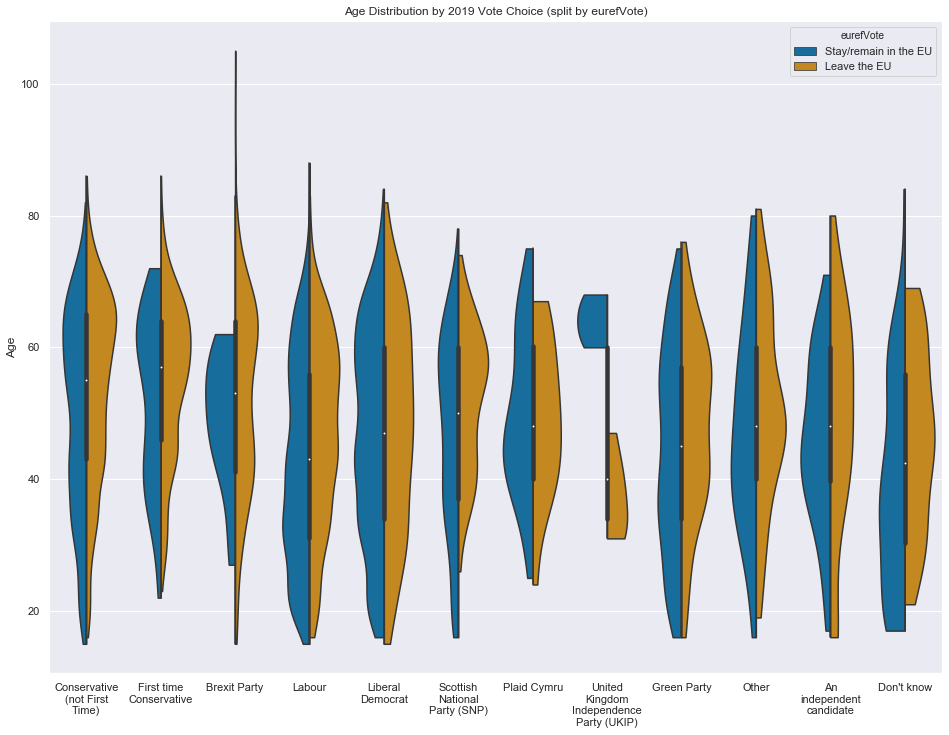

In [97]:
import textwrap
plt.figure(figsize=(16,12))
sns.violinplot(data = df.loc[weighted_ids],x="generalElectionVoteW19",y="Age",hue="eurefVote",split=True,cut=0, order=order);
# plt.xticks()
plt.gca().set_xticklabels([textwrap.fill(e, 12) for e in order]);
plt.xlabel("");
plt.title("Age Distribution by 2019 Vote Choice (split by eurefVote)");

Text(0.5, 1.0, 'Age Distribution by 2019 Vote Choice (split by gender)')

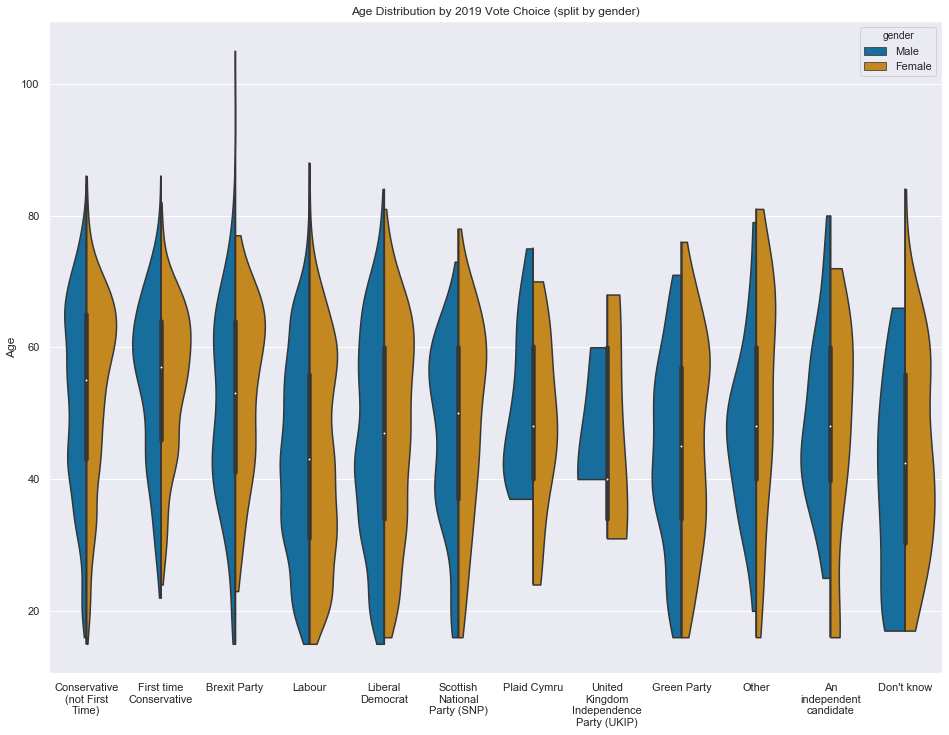

In [98]:
import textwrap
plt.figure(figsize=(16,12))
sns.violinplot(data = df.loc[weighted_ids],x="generalElectionVoteW19",y="Age",hue="gender",split=True,cut=0, order=order);
# plt.xticks()
plt.gca().set_xticklabels([textwrap.fill(e, 12) for e in order]);
plt.xlabel("");
plt.title("Age Distribution by 2019 Vote Choice (split by gender)");